# Part 2: Find Influencers from Reddit

### Select the '0sanitymemes' as our subreddit

In [96]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import zstandard as zstd
import numpy as np

# Function to read a .zst compressed file into a pandas DataFrame
def read_zst(file_path):
    with open(file_path, 'rb') as fh:
        dctx = zstd.ZstdDecompressor(max_window_size=2147483648)
        with dctx.stream_reader(fh) as reader:
            return pd.read_json(reader, lines=True)

filepath_to_submissions = 'Catmemes_submissions.zst'
filepath_to_comments = 'Catmemes_comments.zst'

df_submissions = read_zst(filepath_to_submissions)
df_comments = read_zst(filepath_to_comments)


In [97]:
df_submissions.shape

(21284, 127)

In [98]:
df_comments.shape

(29418, 73)

In [99]:
df_submissions.columns

Index(['num_comments', 'mod_reports', 'author_flair_css_class',
       'distinguished', 'over_18', 'ups', 'author', 'link_flair_text',
       'gilded', 'score',
       ...
       'is_created_from_ads_ui', 'retrieved_utc', 'top_awarded_type',
       'url_overridden_by_dest', 'gallery_data', 'is_gallery',
       'media_metadata', 'tournament_data', 'poll_data', 'call_to_action'],
      dtype='object', length=127)

In [100]:
df_submissions[:10].head()

,num_comments,mod_reports,author_flair_css_class,distinguished,over_18,ups,author,link_flair_text,gilded,score,...,is_created_from_ads_ui,retrieved_utc,top_awarded_type,url_overridden_by_dest,gallery_data,is_gallery,media_metadata,tournament_data,poll_data,call_to_action
0,4,[],None,None,False,8.0,Leefan,None,0,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,[],None,None,False,1.0,astrosnax,None,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,[],None,None,False,1.0,EZDOGLAD,None,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,[],None,None,False,1.0,damn_meme,None,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,[],None,None,False,2.0,Sirinon,None,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
df_submissions.head()

,num_comments,mod_reports,author_flair_css_class,distinguished,over_18,ups,author,link_flair_text,gilded,score,...,is_created_from_ads_ui,retrieved_utc,top_awarded_type,url_overridden_by_dest,gallery_data,is_gallery,media_metadata,tournament_data,poll_data,call_to_action
0,4,[],None,None,False,8.0,Leefan,None,0,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,[],None,None,False,1.0,astrosnax,None,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,[],None,None,False,1.0,EZDOGLAD,None,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,[],None,None,False,1.0,damn_meme,None,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,[],None,None,False,2.0,Sirinon,None,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
df_comments.columns

Index(['author_flair_css_class', 'score', 'ups', 'score_hidden', 'link_id',
       'name', 'edited', 'author_flair_text', 'author', 'gilded', 'subreddit',
       'id', 'downs', 'created_utc', 'retrieved_on', 'controversiality',
       'body', 'archived', 'subreddit_id', 'parent_id', 'distinguished',
       'removal_reason', 'stickied', 'can_gild', 'approved_at_utc',
       'banned_at_utc', 'can_mod_post', 'collapsed', 'collapsed_reason',
       'is_submitter', 'permalink', 'subreddit_type', 'no_follow',
       'send_replies', 'author_flair_template_id', 'approved_by', 'banned_by',
       'body_html', 'likes', 'mod_reports', 'num_reports', 'replies',
       'report_reasons', 'saved', 'user_reports',
       'author_flair_background_color', 'author_flair_richtext',
       'author_flair_text_color', 'author_flair_type', 'rte_mode',
       'author_created_utc', 'author_fullname', 'subreddit_name_prefixed',
       'gildings', 'author_patreon_flair', 'quarantined', 'author_cakeday',
       'l

In [103]:
df_comments.head()

,author_flair_css_class,score,ups,score_hidden,link_id,name,edited,author_flair_text,author,gilded,...,collapsed_because_crowd_control,author_premium,treatment_tags,top_awarded_type,comment_type,collapsed_reason_code,retrieved_utc,author_is_blocked,unrepliable_reason,editable
0,NaN,2,2.0,0.0,t3_1c1bo5,t1_ccgcy8l,0,None,Cloudslife,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,2,2.0,0.0,t3_1c1bo5,t1_cddvshu,0,[CatMod],_Blade,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,2,2.0,0.0,t3_1c1bo5,t1_cde0s3l,0,None,Sirinon,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,1,1.0,0.0,t3_1c1bo5,t1_cdeehfy,0,[CatMod],_Blade,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1,1.0,0.0,t3_1qotlf,t1_cdexivh,0,None,free2me_ipad,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
# Remove deleted account
df_comments = df_comments[df_comments['author'] != "[deleted]"]
df_submissions = df_submissions[df_submissions['author'] != "[deleted]"]

### Merge the submissions and comments data

In [105]:
# Create a dictionary to quickly check if a parent_id is a submission
submission_id_set = set(df_submissions['id'])

# Function to categorize the link type
def categorize_link(parent_id):
    # Prefix 't3_' is for submissions, 't1_' for comments in Reddit's API
    # Remove the prefix from parent_id
    parent_id_no_prefix = parent_id[3:]
    
    # Check if the modified parent_id is in submission_id_set
    if parent_id_no_prefix in submission_id_set:
        return 'respond to a submission'
    else:
        return 'respond to a comment'

# Apply the function to the comments DataFrame
df_comments['Link Type'] = df_comments['parent_id'].apply(categorize_link)

# Construct the data for network analysis
network_data = df_comments[['id', 'parent_id', 'Link Type']]
network_data.rename(columns={'id': 'Child ID', 'parent_id': 'Parent ID'}, inplace=True)


/Users/lauray/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


### Network Analysis - comment

In [106]:
# Create a graph for the network analysis
G = nx.from_pandas_edgelist(network_data, source='Parent ID', target='Child ID', edge_attr='Link Type', create_using=nx.DiGraph())

# Information about the graph
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Network density:", nx.density(G))

Number of nodes: 39461
Number of edges: 26428
Network density: 1.6972238675914667e-05


In [107]:
network_data.head()

,Child ID,Parent ID,Link Type
0,ccgcy8l,t3_1c1bo5,respond to a submission
1,cddvshu,t1_ccgcy8l,respond to a comment
2,cde0s3l,t1_cddvshu,respond to a comment
3,cdeehfy,t1_cde0s3l,respond to a comment
4,cdexivh,t3_1qotlf,respond to a submission


### Network Analysis - Author

In [122]:
# Map submission IDs to authors
submissions_id_author_map = pd.Series(df_submissions.author.values, index=df_submissions.id).to_dict()

# Map comment IDs to authors
comments_id_author_map = pd.Series(df_comments.author.values, index=df_comments.id).to_dict()

# Function to map ID to author
def map_id_to_author_parent(id):
    # Remove prefix
    id_no_prefix = id[3:]
    
    if id.startswith('t3_'):  # Submission ID
        return submissions_id_author_map.get(id_no_prefix, np.nan)
    elif id.startswith('t1_'):  # Comment ID
        return comments_id_author_map.get(id_no_prefix, np.nan)
    else:
        return np.nan 

def map_id_to_author_child(id):
    return comments_id_author_map.get(id, np.nan)

author_network_data = network_data.copy()

# Apply the mapping function to transform IDs to authors
author_network_data['Parent Author'] = network_data['Parent ID'].apply(map_id_to_author_parent)
author_network_data['Child Author'] = network_data['Child ID'].apply(map_id_to_author_child)


In [124]:

# Create a new DataFrame for the author-based network
author_network_data = author_network_data[['Child Author', 'Parent Author', 'Link Type']].dropna().drop_duplicates()

# Create a graph from the author-based network data
G_authors = nx.from_pandas_edgelist(
    author_network_data,
    source='Parent Author',
    target='Child Author',
    edge_attr='Link Type',
    create_using=nx.DiGraph()
)

In [137]:
# Information about the graph
print("Number of nodes:", G_authors.number_of_nodes())
print("Number of edges:", G_authors.number_of_edges())
print("Network density:", nx.density(G_authors))

Number of nodes: 12021
Number of edges: 22488
Network density: 0.00015563446165549723


### Calculate the network measures

In [136]:
# Calculate centrality measures
degree = nx.degree_centrality(G_authors)
betweenness = nx.betweenness_centrality(G_authors)
closeness = nx.closeness_centrality(G_authors)

# Combine all centrality measures into a DataFrame
centrality_measures = pd.DataFrame({
    'Degree': degree,
    'Betweenness': betweenness,
    'Closeness': closeness
})

#### Create metrics for authors

In [139]:
## create columns to measure the responses to submissions/comments received by the author

# Count comments responding to other comments
count_comments_to_comments = network_data[network_data['Link Type'] == 'respond to a comment'].groupby('Parent ID').size()

# Count comments responding to submissions
count_comments_to_submissions = network_data[network_data['Link Type'] == 'respond to a submission'].groupby('Parent ID').size()

count_comments_to_comments_df = count_comments_to_comments.reset_index(name='count_comments_to_comments')
count_comments_to_submissions_df = count_comments_to_submissions.reset_index(name='count_comments_to_submissions')

counts_df = pd.merge(count_comments_to_comments_df, count_comments_to_submissions_df, on='Parent ID', how='outer').fillna(0)

# remove prefix
counts_df['Parent ID'] = counts_df['Parent ID'].str.replace(r'^t1_|^t3_', '', regex=True)

# map the authors
submissions_id_author_map = pd.Series(df_submissions.author.values, index=df_submissions.id).to_dict()
comments_id_author_map = pd.Series(df_comments.author.values, index=df_comments.id).to_dict()

# combine the mappings
id_author_map = {**submissions_id_author_map, **comments_id_author_map}

counts_df['author'] = counts_df['Parent ID'].map(id_author_map)

# groupby based on the same parent id
counts_df = counts_df.groupby('author').sum().reset_index()

counts_df.info()
counts_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6380 entries, 0 to 6379
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   author                         6380 non-null   object 
 1   count_comments_to_comments     6380 non-null   float64
 2   count_comments_to_submissions  6380 non-null   float64
dtypes: float64(2), object(1)
memory usage: 149.7+ KB


,author,count_comments_to_comments,count_comments_to_submissions
0,--Magical_Otter--,1.0,0.0
1,--an0nymous--,0.0,1.0
2,-BabaGanoosh-,0.0,1.0
3,-BooBoom,0.0,5.0
4,-Exility-,0.0,8.0
...,...,...,...
6375,zuyon789,1.0,2.0
6376,zweifachr,0.0,1.0
6377,zxcvfdsaa,0.0,11.0
6378,zymoticjasmine19,1.0,0.0


In [140]:
# the number of submissions per author
submissions_count = df_submissions.groupby('author').size().reset_index(name='submissions_count')

# the number of comments per author
comments_count = df_comments.groupby('author').size().reset_index(name='comments_count')

# Merge the two dataframes on the author column
author_metrics = pd.merge(submissions_count, comments_count, on='author', how='outer').fillna(0)

# merge counts_df on the author column
author_metrics = pd.merge(counts_df, author_metrics, on='author', how='outer').fillna(0)

# merge network measures on the author column
author_metrics['degree'] = author_metrics['author'].map(degree)
author_metrics['betweenness'] = author_metrics['author'].map(betweenness)
author_metrics['closeness'] = author_metrics['author'].map(closeness)


In [141]:
author_metrics

,author,count_comments_to_comments,count_comments_to_submissions,submissions_count,comments_count,degree,betweenness,closeness
0,--Magical_Otter--,1.0,0.0,0.0,1.0,0.000166,0.0,0.000111
1,--an0nymous--,0.0,1.0,1.0,0.0,0.000083,0.0,0.000000
2,-BabaGanoosh-,0.0,1.0,1.0,0.0,0.000083,0.0,0.000000
3,-BooBoom,0.0,5.0,2.0,0.0,0.000416,0.0,0.000000
4,-Exility-,0.0,8.0,1.0,0.0,0.000666,0.0,0.000000
...,...,...,...,...,...,...,...,...
16249,zoeyandere78,0.0,0.0,0.0,1.0,0.000083,0.0,0.000083
16250,zombie_mimic,0.0,0.0,0.0,1.0,0.000083,0.0,0.000111
16251,zomembire,0.0,0.0,0.0,1.0,0.000083,0.0,0.052225
16252,zylon900,0.0,0.0,0.0,1.0,0.000083,0.0,0.049210


#### Add Additional metrics

From part 1 model, the important features to define an influencer on Twitter are:  
1. follower count  
2. listed count
3. mentioned received

However, not all the features are equivalent on Reddit. How much one receives attention from others are important in predicting influence. So what can be applied on Reddit dataset could be:
1. score - engagement of content
2. total awards received - value of content
3. comments received - already have

In [142]:
# Calculate the average score of submissions for each author
submission_score_avg = df_submissions.groupby('author')['score'].mean().reset_index(name='submissions_score')

# Calculate the average score of comments for each author
comment_score_avg = df_comments.groupby('author')['score'].mean().reset_index(name='comments_score')

# Calculate the average awards of submissions for each author
submission_awards_avg = df_submissions.groupby('author')['total_awards_received'].mean().reset_index(name='submissions_awards')

# Calculate the average awards of comments for each author
comment_awards_avg = df_comments.groupby('author')['total_awards_received'].mean().reset_index(name='comments_awards')

author_metrics = pd.merge(submission_score_avg, author_metrics, on='author', how='outer')
author_metrics = pd.merge(comment_score_avg, author_metrics, on='author', how='outer')
author_metrics = pd.merge(author_metrics, submission_awards_avg, on='author', how='outer')
author_metrics = pd.merge(author_metrics, comment_awards_avg, on='author', how='outer')

# Fill missing values with 0
author_metrics.fillna(0, inplace=True)

author_metrics

,author,comments_score,submissions_score,count_comments_to_comments,count_comments_to_submissions,submissions_count,comments_count,degree,betweenness,closeness,submissions_awards,comments_awards
0,--Magical_Otter--,5.0,0.0,1.0,0.0,0.0,1.0,0.000166,0.0,0.000111,0.0,0.0
1,-Azwel-,6.0,0.0,0.0,0.0,0.0,1.0,0.000083,0.0,0.059845,0.0,0.0
2,-Doxter-,2.0,0.0,0.0,0.0,0.0,1.0,0.000083,0.0,0.056987,0.0,0.0
3,-Gravemoss29-,3.0,0.0,0.0,0.0,0.0,2.0,0.000166,0.0,0.000166,0.0,0.0
4,-Greenlung,6.5,0.0,1.0,0.0,0.0,2.0,0.000250,0.0,0.069207,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
16249,zuzunicka,0.0,15.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0
16250,zweifachr,0.0,133.0,0.0,1.0,1.0,0.0,0.000083,0.0,0.000000,0.0,0.0
16251,zxcvfdsaa,0.0,953.0,0.0,11.0,1.0,0.0,0.000915,0.0,0.000000,0.0,0.0
16252,zztop5269,0.0,41.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0


In [143]:
author_metrics.columns

Index(['author', 'comments_score', 'submissions_score',
       'count_comments_to_comments', 'count_comments_to_submissions',
       'submissions_count', 'comments_count', 'degree', 'betweenness',
       'closeness', 'submissions_awards', 'comments_awards'],
      dtype='object')

#### Calculate the influencer score

In [144]:
# Normalize the metrics
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

metrics_columns = ['comments_score', 'submissions_score',
       'count_comments_to_comments', 'count_comments_to_submissions',
       'submissions_count', 'comments_count', 'degree', 'betweenness',
       'closeness', 'submissions_awards', 'comments_awards']
author_metrics[metrics_columns] = scaler.fit_transform(author_metrics[metrics_columns])

# Define your metrics and their corresponding weights
metrics_and_weights = {
    'comments_score': 0.2, 
    'submissions_score': 0.2,
    'count_comments_to_comments': 0.1, 
    'count_comments_to_submissions': 0.1,
    'submissions_count': 0.03, 
    'comments_count': 0.03,
    'degree': 0.1, 
    'betweenness': 0.05,
    'closeness': 0.05, 
    'submissions_awards': 0.07, 
    'comments_awards': 0.07
}

# Initialize the score column to 0
author_metrics['score'] = 0

# Calculate the score using the defined weights
for metric, weight in metrics_and_weights.items():
    author_metrics['score'] += weight * author_metrics[metric]

# Sort by score to identify the top 20 influencers
top_20_influencers = author_metrics.sort_values(by='score', ascending=False).head(20)
print(top_20_influencers[['author', 'score']])


                   author      score
9042           pcangelnow  20.135601
6745     butnobodycame123  19.354229
6395           anners6611  14.579908
5487             TheWappa   9.030503
12547  Prestigious-Ad2859   8.932103
3307               MS0410   8.109476
10350    yourfairymonzter   7.390610
5641     Trainmodeler8888   7.375720
786         Brass_Bastard   6.803401
393             Annupanda   6.678234
1203   Correct-Basil-8397   5.039209
10162         warlocky567   4.792229
1615     DueNectarine8151   4.682962
3057        LambdaKraut57   4.603072
7532           fynn_luca_   4.561835
1179    ConstipatedGibbon   4.434968
10347       youknownuthin   4.331425
10882       CatBonk_Admin   4.273184
3279             Lyssepoo   4.179776
3530            MikalKing   4.072285


#### **Influencer Score Calculation Criteria**

To define the top 20 influencers in a Reddit community, we consider several metrics that reflect different aspects of user engagement and community recognition. Each metric is assigned a weight based on its perceived importance in indicating influence. The following is a breakdown of these metrics and their respective weights:

1. **Score (Engagement Score)**  
   - **Description:** The score, calculated as the difference between the number of upvotes and the number of downvotes a post or comment has received, represents the engagement level of the content.
   - **Weight:** 0.2 for each (comments and submissions score).

2. **Comments Received (Engagement from Different Perspective)**
   - **Description:** The number of comments received on a user's submissions offers another perspective on content engagement.
   - **Weight:** 0.1 for comments received on submissions.

3. **Submissions/Comments Count (Activity Level)**
   - **Description:** The total count of submissions and comments made by a user. Based on findings from an initial model, the features representing how much one engages with the community by posting or commenting are less important in predicting influence.
   - **Weight:** 0.03 for each (submissions count and comments count).

4. **Network Features (Community Interaction)**
   Based on the part 1 model, the network measures are not that important as we expected.
   - **Degree**
     - **Description:** Identifies users who are highly active and directly interact with many parts of the community. It is relatively important in the context of finding the top 20 influencers.
     - **Weight:** 0.1.
   - **Betweenness**
     - **Description:** Highlights users who act as key connectors or brokers within the community, possibly mediating between different groups or discussions.
     - **Weight:** 0.05.
   - **Closeness**
     - **Description:** Indicates how well-placed a user is to spread information rapidly through the community.
     - **Weight:** 0.05.

5. **Awards (Content Value)**
   - **Description:** Awards on Reddit are tokens of appreciation that users can give to posts or comments they find particularly valuable, insightful, funny, or noteworthy. Receiving awards indicates that the community values the content highly enough to spend Reddit Coins.
   - **Weight:** 0.07 for each (awards received on comments and submissions).

The influencer score for each user is calculated by aggregating these metrics according to their weights, aiming to capture a comprehensive view of an individual's influence within the Reddit community.


#### Create the network visual for Top 100 influencers

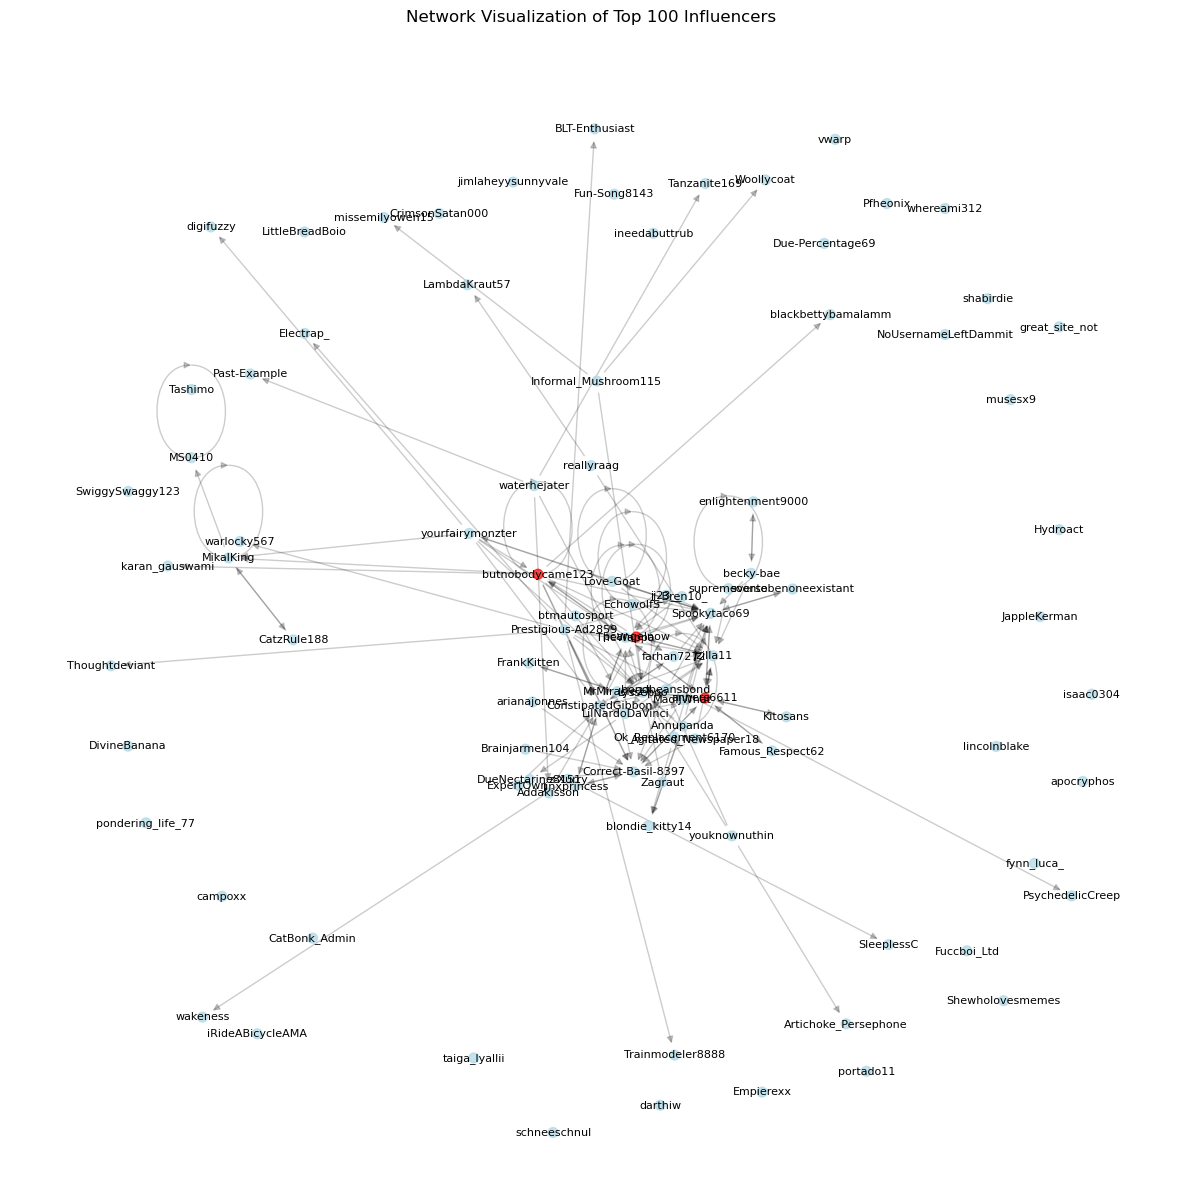

In [145]:
plt.figure(figsize=(15, 15))

pos = nx.spring_layout(subG, k=0.1, iterations=20)

all_nodes = list(subG.nodes())

top_3_authors = top_100_influencers.head(3).tolist()

# Create a color map, red for top 3 influencers and black for others
node_color = ['red' if node in top_3_authors else 'lightblue' for node in all_nodes]

# Draw nodes with the color map
nx.draw_networkx_nodes(subG, pos, node_color=node_color, node_size=50, alpha=0.7)

# Draw edges and labels
nx.draw_networkx_edges(subG, pos, alpha=0.2)
nx.draw_networkx_labels(subG, pos, font_size=8)

plt.title('Network Visualization of Top 100 Influencers')
plt.axis('off')  # Hide axis
plt.show()
